In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels 
import pywt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

## Interpreting Partial Autocorrelation

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c


https://datascience.stackexchange.com/questions/39065/how-is-pacf-analysis-output-related-to-lstm

When used for time series, LSTM (or any Neural Network approach) fall under the category of auto-regressive models. The most general formulation of an auto-regressive model is:

Yt=f(Yt−1,Yt−2,...,Yt−n) with n the number of past lags to include in your model.

When using a neural network for univariate time series modeling, n will determine the number of input neurons to use (It could be n, or could be n+k, with k additional causal features).

The PACF will help you determine n.

The key here is that neural networks are a generalization of AR(p) models.

<img src = "Financial_Forecasting_Model.PNG" width="500" height="500">

## Removing (high-frequency) noise using the DWT

In [4]:
time = np.linspace(0, 1, num=2048)

chirp_signal_noise = [np.sin(250 * np.pi * x**2) + np.random.normal(10, 8**2)*np.random.choice([-1,1]) for x in time]

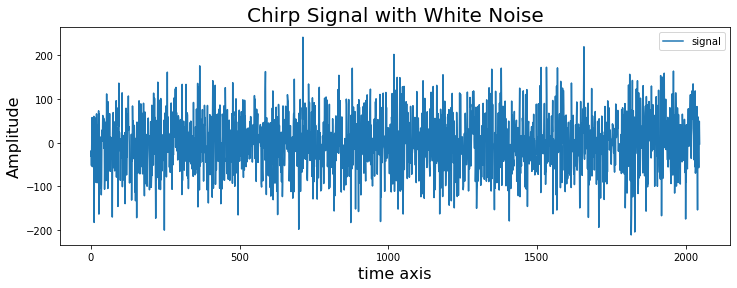

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(chirp_signal_noise, label='signal')
ax.legend(loc='upper right')
ax.set_title('Chirp Signal with White Noise', fontsize=20)
ax.set_xlabel('time axis', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
plt.show()

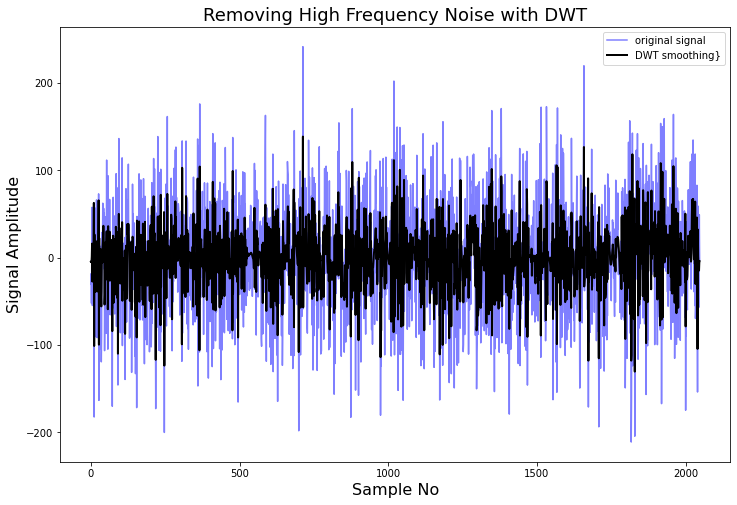

In [10]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(chirp_signal_noise, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(chirp_signal_noise, 0.2)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()



## Analysing Partial Autocorrelation

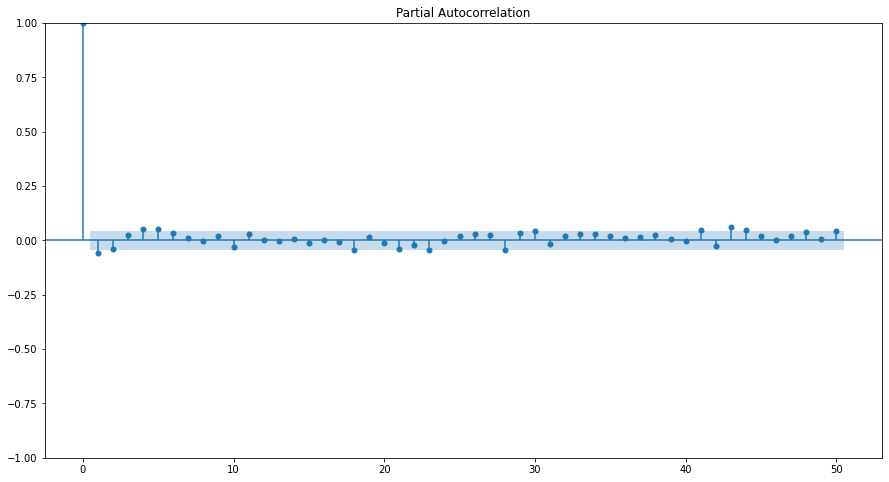

In [17]:
plt.rcParams["figure.figsize"] = (15,8)
plot_pacf(rec, lags = 50)
plt.show()

In [19]:
pacf(rec)

array([ 1.        , -0.06013741, -0.04183522,  0.0261599 ,  0.05363305,
        0.05223117,  0.03582507,  0.01285004, -0.00441734,  0.01825068,
       -0.03167466,  0.02933158,  0.00138372, -0.00423457,  0.00822156,
       -0.01003884,  0.00331438, -0.00581153, -0.04353256,  0.01516407,
       -0.00998901, -0.0410543 , -0.01917878, -0.04305106, -0.00235238,
        0.02088656,  0.02827302,  0.02571055, -0.04396821,  0.03388726,
        0.04296567, -0.01478086,  0.01794906,  0.03035131])

## Discrete Wavelet Transform Analysis

In [22]:
def plot_frequency_subbands(signal, wavelet_coeff):

    n_plots = len(wavelet_coeff) +1 

    fig, axarr = plt.subplots(nrows=n_plots , ncols=1, figsize=(10,15))

    ii = 0
    axarr[ii].set_title("Original Signal", fontsize=8)
    axarr[ii].set_ylabel("Original Signal", fontsize=8, rotation=90)
    axarr[ii].plot(signal, 'b')
    axarr[ii].set_yticklabels([])

    for ii in range(1 , n_plots ):
        if ii == 1:
            axarr[ii].set_title("Frequency Subbands", fontsize=8)
            axarr[ii].set_ylabel("Aprox. {}".format(ii), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'r')
            axarr[ii].set_yticklabels([])
        else:
            axarr[ii].set_ylabel("Detail {}".format(ii -1), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'g')
            axarr[ii].set_yticklabels([])
        
    plt.tight_layout()
    plt.show()


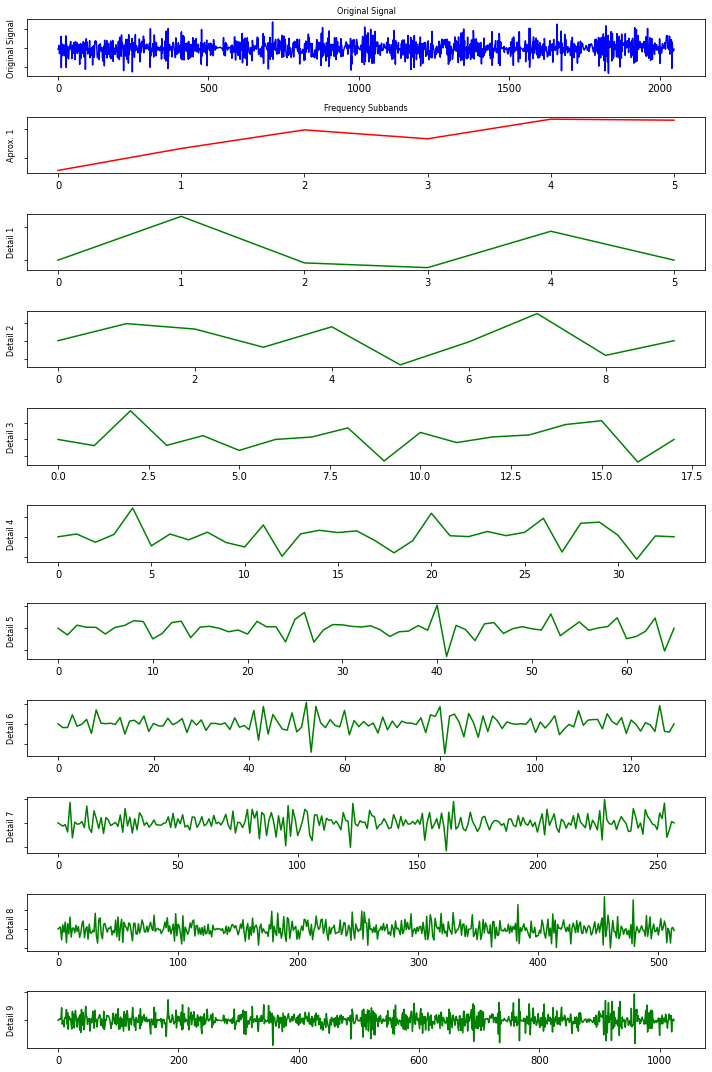

In [23]:
ts = rec
waveletname = 'rbio3.1' #'db2'
coeff = pywt.wavedec(ts, waveletname)


plot_frequency_subbands(signal = ts, 
                        wavelet_coeff = coeff)
